In [ ]:


import os
import requests
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from io import BytesIO
from PIL import Image, ImageTk
import tkinter as tk
from tkinter import filedialog, messagebox

# Keras imports
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

# Paths & parameters
CSV_PATH = r"C:\Users\akash\OneDrive\Desktop\coding AP\ML_Pro\artists.csv"
DATA_DIR = r"C:\Users\akash\OneDrive\Desktop\coding AP\ML_Pro\resized\resized"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 39

INITIAL_EPOCHS = 10
FINE_TUNE_EPOCHS = 10
TOTAL_EPOCHS = INITIAL_EPOCHS + FINE_TUNE_EPOCHS


In [2]:
# Load CSV metadata
artists_df = pd.read_csv(CSV_PATH)
print(f"Total artists in CSV: {len(artists_df)}")

# Verify folder structure
folder_artists = set(os.listdir(DATA_DIR))
csv_artists = set(artists_df['name'])
if folder_artists != csv_artists:
    print("Warning: Folder structure doesn't match CSV entries")
    print("Missing folders:", csv_artists - folder_artists)
else:
    print("✅ Folder structure verified")

# Create data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.2
)

train_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)


Total artists in CSV: 50
Missing folders: {'Caravaggio', 'Georges Seurat', 'Eugene Delacroix', 'Diego Velazquez', 'Jackson Pollock', 'Raphael', 'Paul Cezanne', 'Michelangelo', 'Albrecht Dürer', 'Rembrandt', 'Titian'}
Found 5709 images belonging to 39 classes.
Found 1405 images belonging to 39 classes.


In [3]:
def create_model():
    base_model = MobileNetV2(
        input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False  # Freeze base initially

    inputs = tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
    x = base_model(inputs, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    outputs = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss=CategoricalCrossentropy(),
        metrics=['accuracy']
    )
    return model

model = create_model()
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 39)             │        10,023 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,595,943 (9.90 MB)

 Trainable params: 337,959 (1.29 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [4]:
early_stop = EarlyStopping(patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)

history = model.fit(
    train_generator,
    epochs=INITIAL_EPOCHS,  # 10
    validation_data=val_generator,
    callbacks=[early_stop, checkpoint, reduce_lr]
)


C:\Users\akash\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 170s 932ms/step - accuracy: 0.2251 - loss: 3.0819 - val_accuracy: 0.4754 - val_loss: 1.9295 - learning_rate: 0.0010
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 235s 1s/step - accuracy: 0.4705 - loss: 1.9341 - val_accuracy: 0.5367 - val_loss: 1.7177 - learning_rate: 0.0010
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 213s 1s/step - accuracy: 0.5399 - loss: 1.6470 - val_accuracy: 0.5409 - val_loss: 1.6278 - learning_rate: 0.0010
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 189s 1s/step - accuracy: 0.5756 - loss: 1.4530 - val_accuracy: 0.5794 - val_loss: 1.5425 - learning_rate: 0.0010
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 214s 1s/step - accuracy: 0.6034 - loss: 1.3764 - val_accuracy: 0.5815 - val_loss: 1.5000 - learning_rate: 0.0010
Epoch 6/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 216s 1s/step - accuracy: 0.6283 - loss: 1.2589 - val_accuracy: 0.5943 - val_loss: 1.4485 - learning_rate: 0.0010
Epoch 7/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 236s 1s/step - accuracy: 0.6464 - loss:

In [5]:
base_model = model.layers[1]  # The MobileNetV2 model
unfreeze_layers = int(len(base_model.layers) * 0.2)
for layer in base_model.layers[-unfreeze_layers:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss=CategoricalCrossentropy(),
    metrics=['accuracy']
)

history_fine = model.fit(
    train_generator,
    epochs=TOTAL_EPOCHS,        # 20 total
    initial_epoch=history.epoch[-1],
    validation_data=val_generator,
    callbacks=[early_stop, checkpoint, reduce_lr]
)

model.save('artist_recognition_model.keras')


Epoch 10/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 233s 1s/step - accuracy: 0.7308 - loss: 0.8740 - val_accuracy: 0.6149 - val_loss: 1.3670 - learning_rate: 1.0000e-05
Epoch 11/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 226s 1s/step - accuracy: 0.7703 - loss: 0.7836 - val_accuracy: 0.6391 - val_loss: 1.3321 - learning_rate: 1.0000e-05
Epoch 12/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 214s 1s/step - accuracy: 0.7729 - loss: 0.7448 - val_accuracy: 0.6349 - val_loss: 1.3163 - learning_rate: 1.0000e-05
Epoch 13/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 230s 1s/step - accuracy: 0.7714 - loss: 0.7564 - val_accuracy: 0.6448 - val_loss: 1.2921 - learning_rate: 1.0000e-05
Epoch 14/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 210s 1s/step - accuracy: 0.7736 - loss: 0.7422 - val_accuracy: 0.6534 - val_loss: 1.3026 - learning_rate: 1.0000e-05
Epoch 15/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 216s 1s/step - accuracy: 0.8003 - loss: 0.6860 - val_accuracy: 0.6598 - val_loss: 1.2534 - learning_rate: 1.0000e-05
Epoch 16/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 234s 1s/ste

44/44 ━━━━━━━━━━━━━━━━━━━━ 40s 844ms/step - accuracy: 0.6525 - loss: 1.2814

Final Model Performance:
- Validation Accuracy: 66.69%
- Validation Loss: 1.2531


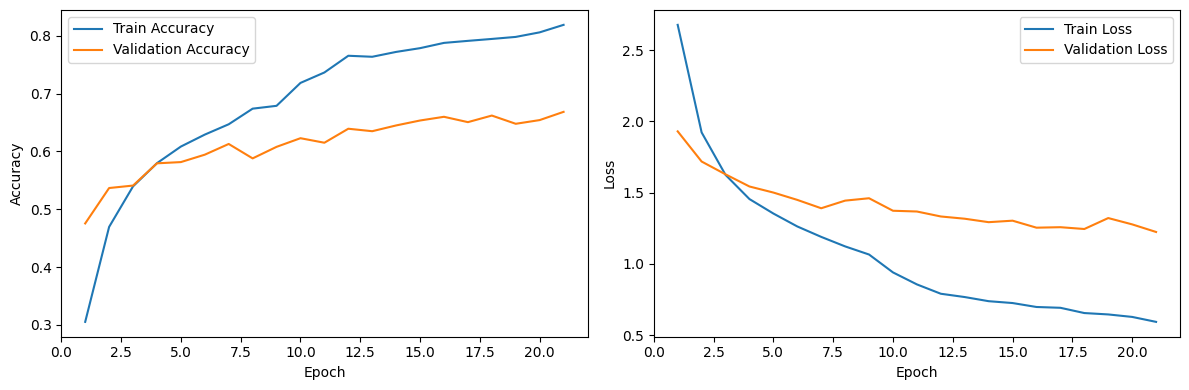

In [6]:
best_model = load_model('best_model.keras')
loss, accuracy = best_model.evaluate(val_generator)
print(f"\nFinal Model Performance:")
print(f"- Validation Accuracy: {accuracy*100:.2f}%")
print(f"- Validation Loss: {loss:.4f}")

def plot_training_history(histories):
    acc = histories[0].history['accuracy'] + histories[1].history.get('accuracy', [])
    val_acc = histories[0].history['val_accuracy'] + histories[1].history.get('val_accuracy', [])
    loss_vals = histories[0].history['loss'] + histories[1].history.get('loss', [])
    val_loss_vals = histories[0].history['val_loss'] + histories[1].history.get('val_loss', [])
    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss_vals, label='Train Loss')
    plt.plot(epochs_range, val_loss_vals, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history([history, history_fine])


In [ ]:
class AdvancedArtAnalyzer:
    def __init__(self, model_path, csv_path, dataset_dir):
        self.model = load_model(model_path)
        self.artists_df = pd.read_csv(csv_path)
        self.dataset_dir = os.path.abspath(dataset_dir)

        self.class_indices = train_generator.class_indices
        self.index_to_artist = {v: k for k, v in self.class_indices.items()}

        self.metadata = {}
        for _, row in self.artists_df.iterrows():
            artist = row['name']
            self.metadata[artist] = {
                'genre': row['genre'],
                'nationality': row['nationality'],
                'bio': row['bio']
            }

        self.genre_to_indices = {}
        for artist, idx in self.class_indices.items():
            genre = self.metadata[artist]['genre']
            self.genre_to_indices.setdefault(genre, []).append(idx)

    def load_image_any_path(self, path):
        """Load an image from a local path or a web URL."""
        if path.startswith('http://') or path.startswith('https://'):
            import requests
            from io import BytesIO
            response = requests.get(path)
            response.raise_for_status()
            image_data = BytesIO(response.content)
            pil_img = Image.open(image_data).convert('RGB')
        else:
            pil_img = Image.open(path).convert('RGB')
        return pil_img

    def analyze_image(self, path):
        pil_img = self.load_image_any_path(path)
        pil_img = pil_img.resize(IMG_SIZE)
        img_array = img_to_array(pil_img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        preds = self.model.predict(img_array)[0]

        abs_path = os.path.abspath(path)
        if abs_path.startswith(self.dataset_dir):
            predicted_index = np.argmax(preds)
            predicted_artist = self.index_to_artist[predicted_index]
            confidence = preds[predicted_index] * 100
            meta = self.metadata[predicted_artist]
            return {
                'pil_img': pil_img,
                'artist': predicted_artist,
                'genre': meta['genre'],
                'nationality': meta['nationality'],
                'confidence': f"{confidence:.1f}%",
                'bio': meta['bio'][:200] + '...'
            }
        else:
            genre_scores = {}
            for genre, indices in self.genre_to_indices.items():
                genre_scores[genre] = sum(preds[i] for i in indices)
            predicted_genre = max(genre_scores, key=genre_scores.get)
            confidence = genre_scores[predicted_genre] * 100
            return {
                'pil_img': pil_img,
                'genre': predicted_genre,
                'confidence': f"{confidence:.1f}%"
            }


In [1]:
def launch_gui():
    analyzer = AdvancedArtAnalyzer('best_model.keras', CSV_PATH, DATA_DIR)

    root = tk.Tk()
    root.title("Beautiful Art Recognition System (Local + URL)")
    root.geometry("800x600")

    # Title Label
    title_label = tk.Label(root, text="Art Recognition System", font=("Arial", 16, "bold"))
    title_label.pack(pady=10)

    # Info Label
    info_label = tk.Label(root, text="Paste a local path or web URL to an image, or browse a local file.\nThen click 'Analyze Painting'.",
                          font=("Arial", 11), wraplength=700)
    info_label.pack(pady=5)

    # Path Frame
    path_frame = tk.Frame(root)
    path_frame.pack(pady=5)

    path_label = tk.Label(path_frame, text="Image Path/URL:", font=("Arial", 10))
    path_label.pack(side="left", padx=5)

    path_var = tk.StringVar()
    path_entry = tk.Entry(path_frame, textvariable=path_var, width=60, font=("Arial", 10))
    path_entry.pack(side="left", padx=5)

    def browse_file():
        filename = filedialog.askopenfilename(title="Select an Image")
        if filename:
            path_var.set(filename)

    browse_btn = tk.Button(path_frame, text="Browse", command=browse_file,
                           bg="#2196F3", fg="white", font=("Arial", 10))
    browse_btn.pack(side="left")

    # Image Display Label
    image_label = tk.Label(root, bg="white")
    image_label.pack(pady=10)

    # Result Text
    result_text = tk.Text(root, height=10, width=80, font=("Arial", 10), wrap="word")
    result_text.pack(pady=10)

    def analyze_painting():
        path = path_var.get().strip()
        if not path:
            messagebox.showerror("Error", "Please enter or select an image path/URL.")
            return
        try:
            results = analyzer.analyze_image(path)

            # Clear previous results
            result_text.delete("1.0", tk.END)

            # Display the image
            pil_img = results['pil_img']
            # For big images, thumbnail it
            disp_img = pil_img.copy()
            disp_img.thumbnail((300, 300))
            tk_img = ImageTk.PhotoImage(disp_img)
            image_label.config(image=tk_img)
            image_label.image = tk_img

            # Display results
            if 'artist' in results:
                # Known dataset painting
                output = (f"Artist: {results['artist']}\n"
                          f"Nationality: {results['nationality']}\n"
                          f"Genre: {results['genre']}\n"
                          f"Confidence: {results['confidence']}\n"
                          f"Bio: {results['bio']}")
            else:
                # External painting
                output = (f"Predicted Genre: {results['genre']}\n"
                          f"Confidence: {results['confidence']}")

            result_text.insert(tk.END, output)

        except Exception as e:
            messagebox.showerror("Error", f"Failed to analyze image:\n{e}")

    # Button Frame
    btn_frame = tk.Frame(root)
    btn_frame.pack(pady=10)

    analyze_btn = tk.Button(btn_frame, text="Analyze Painting", command=analyze_painting,
                            bg="#4CAF50", fg="white", font=("Arial", 12), padx=10, pady=5)
    analyze_btn.pack(side="left", padx=5)

    def exit_app():
        root.destroy()

    exit_btn = tk.Button(btn_frame, text="Exit", command=exit_app,
                         bg="red", fg="white", font=("Arial", 12), padx=10, pady=5)
    exit_btn.pack(side="left", padx=5)

    root.mainloop()


if __name__ == "__main__":
    # After training completes, we can launch the GUI
    launch_gui()


NameError: name 'AdvancedArtAnalyzer' is not defined